# Tutorial 4: Human Breast Cancer Dataset

This tutorial illustrates how to apply S3RL to the Human Breast Cancer dataset from 10X Genomics (Visium platform). The dataset can be accessed at [10X Genomics Portal](https://www.10xgenomics.com/resources/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0), and includes gene expression, spatial coordinates, and H&E-stained images.

After preprocessing, S3RL enhances the spatial gene expression structure and reveals distinct tissue compartments such as tumor, stromal, and immune-rich regions. Spatial patterns of key marker genes like CXCL14 and DDR1 become more sharply localized, aiding in tumor microenvironment analysis.

In [ ]:
from Utility.tools import  load_train_data
import os

dataset = 'Human_Breast_Cancer'
id = ''
pixel_size = 10
img_path = os.path.join('./Img_encoder/models/', dataset, id, 'img_emb.npy')
data_path = './Data'
knn = 5

edge_index, fea, G, G_neg, gt, adata = load_train_data(id=id, 
                                                       knn=knn, 
                                                       data_path=os.path.join(data_path, dataset), 
                                                       img_path=img_path, 
                                                       margin=pixel_size, 
                                                       dataset=dataset, 
                                                       return_adata=True)

In [2]:
from Utility.train_w_data import train_
import yaml

cfg_path = './Best_cfg'
with open(os.path.join(cfg_path, dataset, dataset+'.yaml'), 'r') as f:
    cfg = yaml.safe_load(f)

ari, label_pred, emb, recon = train_(edge_index, fea, G, G_neg, gt, cfg)

print(f'The final ARI is {ari}')

Training:  93%|█████████▎| 1388/1500 [01:49<00:08, 12.64it/s]

Reached the tolerance, early stop training at epoch 1388
The final ARI is 0.6722703784562841


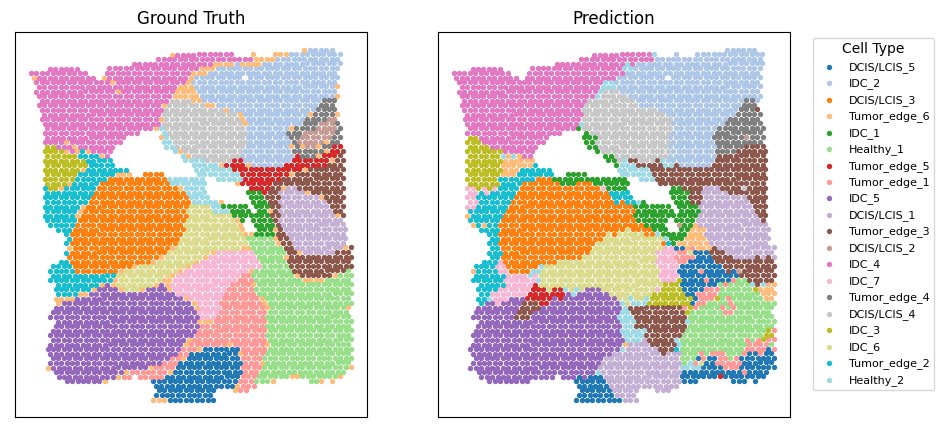

In [14]:
import matplotlib
from Utility.tools import hungarian_match
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

label_pred = hungarian_match(gt, label_pred)
label_dict = dict(zip(adata.obsm['label_dict'].values, adata.obs['Ground Truth'].values))

colors = np.vstack([np.array(matplotlib.colormaps['tab20'].colors), 
                    np.array(matplotlib.colormaps['tab20b'].colors), 
                    np.array(matplotlib.colormaps['tab20c'].colors)])

for j, label in enumerate(np.unique(gt)):
    axs[0].scatter(adata.obsm['spatial'][gt==label, 0], adata.obsm['spatial'][gt==label, 1], color=colors[j], s=8)
    axs[1].scatter(adata.obsm['spatial'][label_pred==label, 0], adata.obsm['spatial'][label_pred==label, 1], color=colors[j], s=8, label=label_dict[label])

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title='Cell Type', title_fontsize=10)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[0].set_title('Ground Truth')
axs[1].set_title('Prediction')

plt.show()